<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Robust Regression

_Authors: Greg Baker (SYD)_

---

<a id="learning-objectives"></a>
### Learning Objectives 
- Revise the limitations and short-comings of OLS and the $R^2$ scoring function
- Know when to use robust regression methods instead of OLS
- Understand how Theil-Sen, RANSAC and Huber work, and what they are optimising for
- Understand the advantages of using median absolute error as a scoring function
- Create a scoring function appropriate for different business scenarios


### Lesson Guide
- [Introduction](#introduction)
- [Review of ordinary least squares and squared error loss](#ols)
- [Robust Regression](#robust)
   - [Theil-Sen](#theilsen)
   - [RANSAC](#ransac)
   - [Huber](#huber)
- [Median absolute error](#mae)
- [Scenario-specific scoring functions](#custom)
    - [Qiqi's Lemonade Stand](#qiqi-lemonade)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import seaborn as sns

% matplotlib inline

<a id="introduction"></a>


# Introduction

Congratulations! You have mastered linear regression. This is one of the most important skills for a 
data scientist to know.

<img src="assets/kdnuggets-plot.jpg">

In this topic you will learn some of the import techniques that data scientists use to make
linear regression work well in a commercial environment:

- A review of ordinary least squares

- Robust regression

- Useful metrics for evaluating how good a line is


This is what separates mediocre data scientists from the ones who can drive value for an organisation


<a name="ols"></a>

## Review of Ordinary Least Squares: $R^2$

---

We have done many examples so far of using ordinary least squares regression (OLS) to find a good linear
model. 

This is the 
technique where we look at all the possible linear models, and try to find the one that has the following
property:

> _When you look at what this model predicts, and compare it to what was in the training data, there will be
> errors. For each point, look at the square of the difference between what was predicted and what it was
> supposed to be. Sum up those squares. The line you are looking for is the one that has the smallest sum._

Occasionally this is reasonable choice.

In [2]:
# To illustrate some of these concepts, we'll make use of this function to draw plots of 
# points, lines through them, and show the size of the error in each case

def fancy_linear_plot(actuals, model, ax, include_error_bars=True):
    ax.scatter(x=actuals.index, y=actuals)
    predictions = pd.Series(index=actuals.index, data=model.predict(actuals.index.values.reshape(-1,1)))
    predictions.plot(c='red', ax=ax)
    squared_difference = 0
    differences = []
    for x in predictions.index:
        true_y = actuals.loc[x]
        predicted_y = predictions.loc[x]
        error_line = pd.Series(index=[x,x],data=[predicted_y,true_y])
        difference = true_y - predicted_y
        squared_difference += difference * difference
        differences.append("%.1f" % (difference * difference,))
        if include_error_bars:
            error_line.plot(ax=ax, linestyle='dashed', c='green')
            ax.annotate("error=%d" % (difference,),xy=(x+0.1,true_y-2 if true_y > predicted_y else true_y+2))
    if include_error_bars:
        title = "Sum of squares difference =\n%s\n = %d"  % (" + ".join(differences), squared_difference)
        ax.set_title(title)

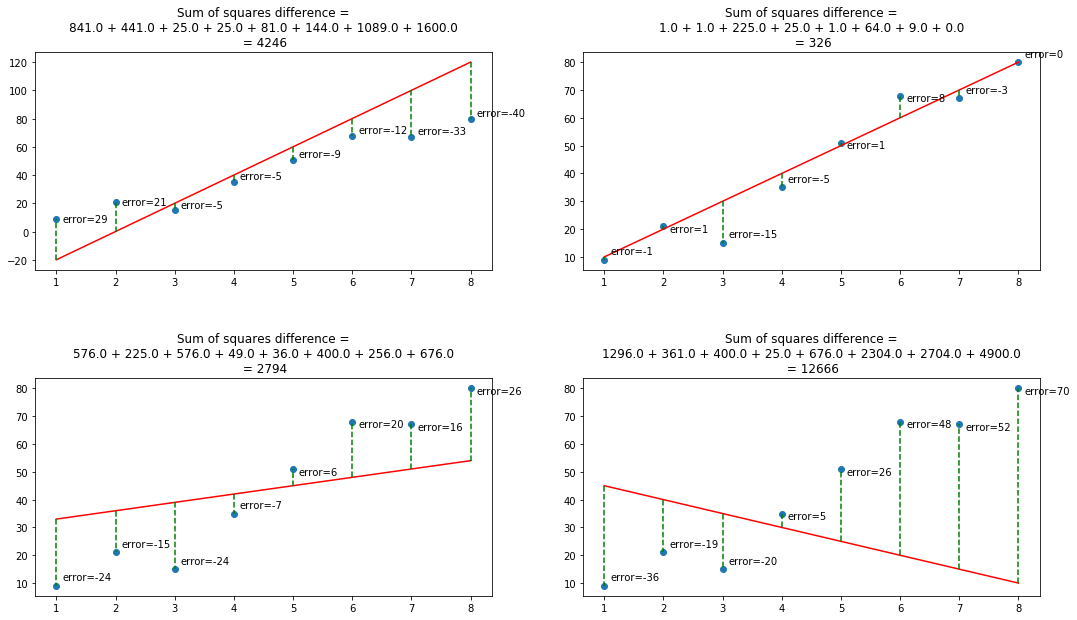

In [3]:
# With this example data, let's look at 4 potential linear models and what they look like:

example_data = pd.Series(
    data=[9,21,15,35,51,68,67,80],
    index=[1,2,3,4,5,6,7,8]
)


(fig, axes) = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
plt.subplots_adjust(hspace=0.5)

lr1 = sklearn.linear_model.LinearRegression()
lr1.coef_ = np.array([20])
lr1.intercept_ = -40
fancy_linear_plot(example_data, lr1, axes[0][0])

lr2 = sklearn.linear_model.LinearRegression()
lr2.coef_ = np.array([10])
lr2.intercept_ = 0
fancy_linear_plot(example_data, lr2, axes[0][1])


lr3 = sklearn.linear_model.LinearRegression()
lr3.coef_ = np.array([3])
lr3.intercept_ = 30
fancy_linear_plot(example_data, lr3, axes[1][0])

lr4 = sklearn.linear_model.LinearRegression()
lr4.coef_ = np.array([-5])
lr4.intercept_ = 50
fancy_linear_plot(example_data, lr4, axes[1][1])

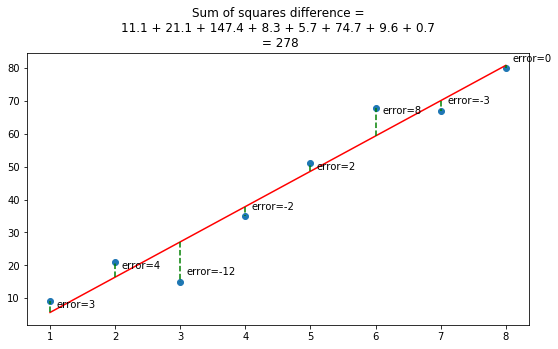

In [4]:
# But with ordinary least squares we can get the one that has the smallest sum-of-squares
(fig, ax) = plt.subplots(figsize=(9,5))
lr3 = sklearn.linear_model.LinearRegression()
lr3.fit(example_data.index.values.reshape(-1,1), example_data)
fancy_linear_plot(example_data, lr3, ax)

# Test your knowledge

1. The line generated by ordinary least squares regression library in
   scikit-learn is the line that minimises $R^2$. True or false?
   
2. Ordinary least squares regression only works when your data has
   two dimensions: 1-dimensional y, and 1-dimensional X. True or false?
   
3. The line found by minimising $R^2$ isn't affected much by outliers. True or false? 

## Why we like $R^2$

- It's a unique answer
- It's easy to calculate because we can use derivatives to create a formula to find it quickly
- It makes sure that big mistakes are as small as they can be

The last point is because even making a small adjustment to the line to shrink the square of a big error
can be be worthwhile even if it means losing accuracy on some small errors.

## The problems with $R^2$

- **One outlier can ruin your whole model**. Ordinary least squares requires each outlier in one direction to have a
corresponding quantity of outliers in the other direction (heteroskedacity)
- It assumes that your $X$ values are measured with no error
- **The dollar cost to a business of a faulty prediction probably doesn't correspond** to the square of how wrong that prediction was. Typically, we want to **maximise the company's profits**, not minimise the squared error in our predictions.


Outside of a science laboratory, it is very, very rare for $R^2$ to be the right thing to use.

----

# What should I use instead of ordinary least squares?

- **Regularization**: when you want to find a simple model (we will have many more modules on this)

- **Robust regression**: when the main challenge is to find a signal in a noisy data set 

Both of these are usually used -- when you know the cost to the business of errors in your model -- in conjunction with **custom scoring functions**.



<a name="#robust"></a>

----

## Robust Regression



Robust Regression is a technique to generate a linear model that is "the best" without being sensitive to 
outliers and noise.

Some of these methods are so simple that they can be done by hand even on large datasets; some are so
complex that they can only be done with modern computers.

They differ in how they define what is "the best linear model": they will almost always not be the same 
answer as the least-squares linear model.

Let's see an example where the least-squares line is really obviously not the right model.

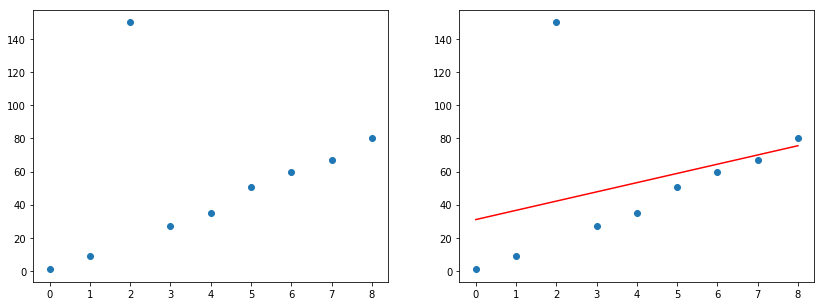

In [7]:
# First draw the picture without any line through it
noisy_example = pd.Series(
    data=[1,9,150,27,35,51,60,67,80],
    index=[0,1,2,3,4,5,6,7,8]
)
(fig, ax) = plt.subplots(figsize=(14,5), ncols=2)
ax[0].scatter(x=noisy_example.index, y=noisy_example)

# Do another chart with ordinary-least-squares model overlay
ols = sklearn.linear_model.LinearRegression()
ols.fit(noisy_example.index.values.reshape(-1,1), noisy_example)
fancy_linear_plot(noisy_example, ols, ax[1], include_error_bars=False)

### Class exercise

1. Describe in words why the ordinary least squares model doesn't do a good job with this
data set. Why does "minimising the sum of the square of the error terms" not model this data
well?

2. (Challenge) What would be a better metric? How could you compare two lines and decide
which one fits the data better? (We will discuss three possible answers in the next pages.)

<a name="theilsen"></a>

----

## Theil-Sen

(Pronounced "Tail-Sen")

The Theil-Sen method is extremely simple, and works surprisingly well.

1. Pick a pair of points at random.
2. Draw a line through them, and remember the gradient of the line.
3. Repeat steps 1 & 2 some number of times (e.g. 25 times).
4. Sort the lines by gradient.
5. Choose the line with the median gradient

(If you have more than two columns in your X dataframe, choose three points and draw a plane. If you have
three colums, choose 4 points and make a hyper-plane, and so on.)

**Theil-Sen definition of best**:  linear model that
isn't extreme; a "typical" linear model where all the other reasonable
linear models are spread out evenly above and below the one that was chosen.

<a name="ransac"></a>

----

## RANSAC

The RANSAC method is nearly as simple as Theil-Sen and can cope with datasets that have huge numbers
of outliers and lots of random noise. Even if nearly 50% of your data is noise, RANSAC can still find
a hidden trend that almost no other algorithm can find.

1. Define a distance to determine what is "close enough". (not that easy actually!) 
2. Pick a random pair of points. Draw a line through them and then count the number of points that are
   "close enough" to the line.
3. Pick another pair of points, draw a line, count the number of points that are close enough to the new
   line. If this line was better than the existing line, discard the existing line; otherwise, discard
   the current line.
4. Repeat step 3 until you haven't seen an improvement in a long time. The line you have is your RANSAC-best
   line.
   
Like RANSAC, this works in higher dimensions: use triples of points forming a plane if you have two columns
in your data frame.

RANSAC's definition of the "best linear model" is the one that is close to a lot of points -- the one
that models the data accurately _the most often_. 


## Example

Let's see how these algorithms work on the data set we just had where ordinary-least-squares did so badly.

The scikit-learn library has functions for Theil-Sen and RANSAC.

Text(5,10,'RANSAC')

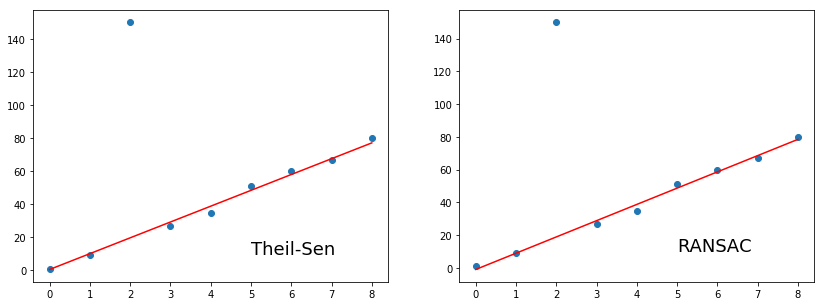

In [15]:
(fig, ax) = plt.subplots(figsize=(14,5), ncols=2)

ts = sklearn.linear_model.TheilSenRegressor()
ts.fit(noisy_example.index.values.reshape(-1,1), noisy_example)
fancy_linear_plot(noisy_example, ts, ax[0], include_error_bars=False)

ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(noisy_example.index.values.reshape(-1,1), noisy_example)
fancy_linear_plot(noisy_example, ransac.estimator_, ax[1], include_error_bars=False)

ax[0].annotate("Theil-Sen", (5,10), size=18)
ax[1].annotate("RANSAC", (5,10), size=18)

#### Remember!

Theil-Sen and RANSAC have their own definitions for "the best linear model". If you measure them
with $R^2$ they will do quite badly!

Text(4,10,'Least Squares')

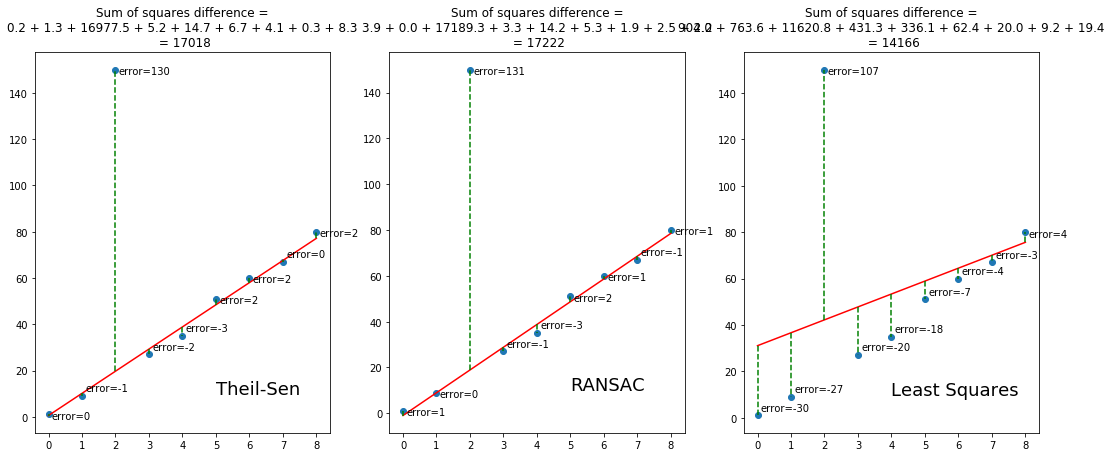

In [16]:
(fig, ax) = plt.subplots(figsize=(18,7), ncols=3)

fancy_linear_plot(noisy_example, ts, ax[0])
fancy_linear_plot(noisy_example, ransac, ax[1])
fancy_linear_plot(noisy_example, ols, ax[2])
ax[0].annotate("Theil-Sen", (5,10), size=18)
ax[1].annotate("RANSAC", (5,10), size=18)
ax[2].annotate("Least Squares", (4,10), size=18)

## Huber (the most important part of this lesson!)

The **Huber** regressor minimises the sum of:
- the absolute value of the prediction error for predictions that were wrong by a long way
- the square of the value of the prediction error for predictions that were close

This turns out to be very effective, and turns out to be one of the most-used robust linear
regressors. Outliers don't have disproportionate effects, but it will still try to minimise
local errors.

Text(6.5,10,'Huber')

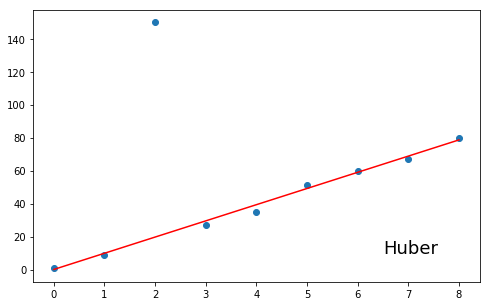

In [17]:
(fig, ax) = plt.subplots(figsize=(8,5), ncols=1)

huber = sklearn.linear_model.HuberRegressor()
huber.fit(noisy_example.index.values.reshape(-1,1), noisy_example)
fancy_linear_plot(noisy_example, huber, ax, include_error_bars=False)

ax.annotate("Huber", (6.5,10), size=18)

## Summary of regressors

| **Regressor**          | Handles Outliers   | **Useful when**                  |
|------------------------|------------|----------------------------------|
| Huber                  | tolerant of unbalanced outliers  | Usually best one to try first    |
| Theil-Sen              | unaffected if < 29% of data     | Your X values have errors and noise         |
| RANSAC                 | unaffected if < 50% of data     | Your Y values have errors and noise         |
| Ordinary least squares | only if normally distributed (rare) | Avoiding large errors is important |


## Test your knowledge

1. What's the difference between a robust regressor and a non-robust regressor?

2. What are the three robust regressors you have learned?

# Scoring

How do we know whether a regressor has worked well or not? What do we mean by "best" line?

There are several ways of scoring a regressor:

- $R^2$ -- if you do this, then ordinary least squares will get you the best line

- Median absolute error -- if this is your measure, you will cope with large numbers of outliers

- Dollar value loss -- if this is your measure, wealth and happiness will come your way.

## Median absolute error

scikit-learn includes several different out-of-the-box scoring functions for regressors, and more than a dozen
scoring functions for classifiers.

**median absolute error** is very commonly used for **noisy data**. You will have some points that you predicted well 
(so the
absolute value of the error will be quite small) and some that you predicted badly (so the absolute value of the
error on those points will be quite large). What is the median of those? 50% of your errors were below this number.

This (and many other) metric functions are defined in `sklearn.metrics.*` but for many of them there is a short-hand
string that can be used (e.g. 'median_absolute_error') any place that a metric is passed as an argument.

In [19]:
# It doesn't normally make sense to measure how well a regressor predicts data that was given to it
# for training, but we'll just do it anyway.
import sklearn.metrics
def score(model):
    predictions = model.predict(noisy_example.index.values.reshape(-1,1))
    return sklearn.metrics.median_absolute_error(noisy_example, predictions)

print("OLS:",score(ols))
print("Theil-Sen:", score(ts))
print("RANSAC:", score(ransac))
print("Huber:", score(huber))

OLS: 18.333333333333336
Theil-Sen: 2.2706832924830884
RANSAC: 1.8288288288288292
Huber: 1.8185376092747987


i.e. for Huber, half the points were predicted within 1.82 of the actual value. Or, to be more negative about it,
for half the points, ordinary-least-squares was more than 18.3333 away from the actual value.

<a name='custom'></a>

----

# Scenario-Specific Scoring Functions

$R^2$ is reasonably common (and often mis-applied), *median absolute error* is commonly used as well. But
by far **the most common scoring method** is to measure the error in **dollars** (or whatever currency your business
uses).

Most data scientists work in for-profit companies. Your model will get used to predict something -- to help
make a decision -- and there will be costs associated with getting it wrong. Often, those costs will be
**asymmetric** (over-estimating might be more expensive than under-estimating).

Some data scientists work for well-funded startups who aren't concerned by dollar costs too much. Usually
the right metric then will involve monthly users or signups or some other growth-relevant metric.

----

<a name="qiqi-lemonade"></a>

## Qiqi's Lemonade Stand

<img src="assets/lemonade-stand.jpg" style="width: 200px; float: left; margin: 20px">

It costs Qiqi 3c to buy the sugar, lemons and cups to make one glass of lemonade. She has to spend this money
to buy the ingredients
up-front at the beginning of the day and can't buy more until the next day if she runs out.
She pays her brother 
a fixed fee of \$2 to make the mixture, regardless of how many cups she sells each day. She charges customers
50c.

She has access to data showing that there is a relationship between the temperature and humidity and the
number of customers that will want to buy a cup of lemonade. She is trying to choose between several
linear models.

Question: what is a good scoring function for Qiqi to use to evaluate which model to use?

A:

Discard the situation where Qiqi decides not to be in business at all. So the \$2 to her brother is fixed and we can ignore it.

Let $X_p$ be the predicted number of customers and $X_a$ be the actual number of customers for a particular day
in the test portion of the database.

- If $X_p > X_a$ (i.e. if she doesn't manage to sell all the lemonades she has prepared) then Qiqi would lose $0.03 * (X_p - X_a)$ in wasted materials if she had followed that model

- If $X_a > X_p$ (i.e. if she doesn't have enough lemonades to satisfy all the possible clients of the day) then Qiqi would lose $0.50 * (X_a - X_p)$ in lost sales if she had followed that model

- If $X_p = X_a$ then Qiqi would waste nothing and lose no sales

Scores closer to zero are better.

In [20]:
def lemonade_scorer(estimator, X, y):
    predictions = list(estimator.predict(X))
    y = list(y)
    score = 0.0
    for i in range(len(y)):
        if predictions[i] > y[i]:
            score -= 0.03 * int(predictions[i] - y[i])
        elif predictions[i] < y[i]:
            score -= 0.5 * int(y[i] - predictions[i])
        else:
            score -= 0.0
    return score

In [21]:
lemonade_stand = pd.read_csv('datasets/lemonade-stand.csv', index_col=0)
lemonade_stand.head()

,Max_Temp_C,humidity,sales
date_index,,,
2016-12-02,37.0,41,26
2016-12-03,26.7,68,25
2016-12-04,30.2,67,28
2016-12-08,34.3,67,31
2016-12-09,28.0,34,24


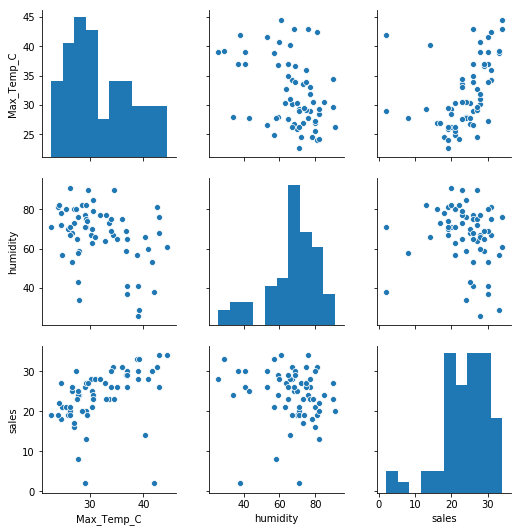

In [22]:
# There is a relationship between temperature and sales.
# There is a (weaker) relationship between increased humidity and decreased sales, which could have
# something to do with whether it was raining or not!
# But there are still about 5 days where sales were much lower than would have been expected.
sns.pairplot(lemonade_stand)

In [23]:
# Split the data into train and test data. If we train on the training data, we can then
# get an estimate on the dollar cost of the model by trying it out on the test data
(Xtrain, Xtest, Ytrain, Ytest) = sklearn.model_selection.train_test_split(lemonade_stand[['Max_Temp_C','humidity']],
                                                                         lemonade_stand.sales)

In [24]:
# Let's try out 4 different linear models: OLS, TheilSen, RANSAC and Huber
lemonade_ols = sklearn.linear_model.LinearRegression()
lemonade_ts = sklearn.linear_model.TheilSenRegressor()
lemonade_ransac = sklearn.linear_model.RANSACRegressor()
lemonade_huber = sklearn.linear_model.HuberRegressor()

In [25]:
# Call .fit() on each model using the training data
lemonade_ols.fit(Xtrain, Ytrain)
lemonade_ts.fit(Xtrain, Ytrain)
lemonade_ransac.fit(Xtrain, Ytrain)
lemonade_huber.fit(Xtrain, Ytrain)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

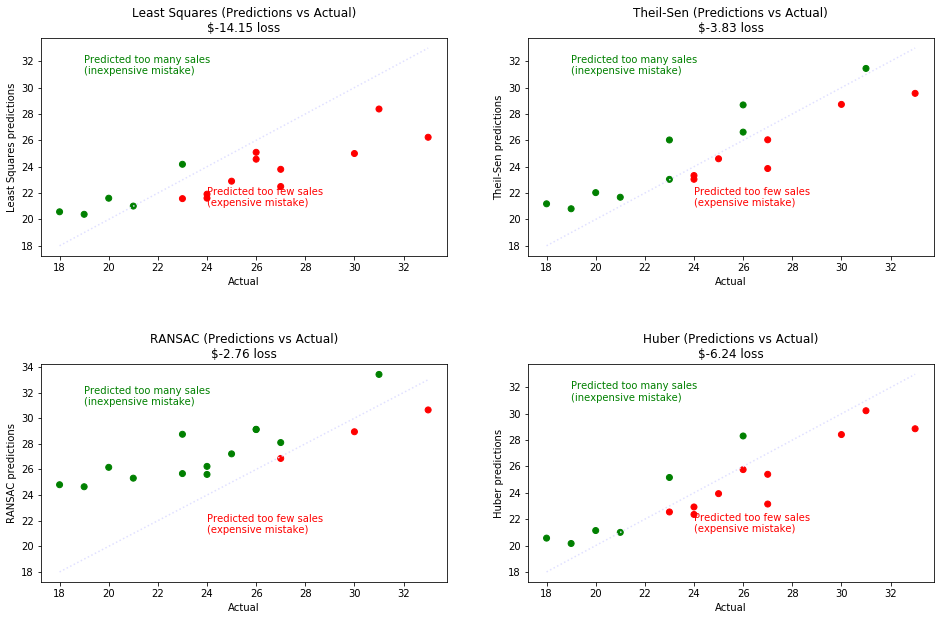

In [26]:
# Do lots of matplotlib magic to help visualise what's going on
(fig, axes) = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
plt.subplots_adjust(hspace=0.5)

def show_predictions(ax, regressor, name):
    predictions = y=regressor.predict(Xtest)
    colouring = np.where(predictions < Ytest, 'red', 'green')
    ax.scatter(x=Ytest, y=predictions, c=colouring)
    ax.set_title(name + " (Predictions vs Actual)\n$%.2f loss" % (lemonade_scorer(regressor, Xtest, Ytest),))
    ax.plot([Ytest.min(),Ytest.max()],[Ytest.min(),Ytest.max()], linestyle='dotted', c='#e0e0ff')
    ax.set_xlabel("Actual")
    ax.set_ylabel(name + " predictions")
    ax.annotate("Predicted too many sales\n(inexpensive mistake)", xy=(Ytest.min()+1, Ytest.max()-2), color='green')
    ax.annotate("Predicted too few sales\n(expensive mistake)", xy=(Ytest.max()-9,Ytest.min()+3), color='red')
    
show_predictions(axes[0][0], lemonade_ols, 'Least Squares')
show_predictions(axes[0][1], lemonade_ts, 'Theil-Sen')
show_predictions(axes[1][0], lemonade_ransac, 'RANSAC')
show_predictions(axes[1][1], lemonade_huber, 'Huber')

In words, what's going on is that the least squares regression is trying really hard to minimise the error from
the 5 or so times that sales were far lower than would have been expected from the temperature and humidity.

But saving a few cents on the input materials is overwhelmed by the losses that come from not predicting
sufficiently high on typical days.

# Topic Recap

## Methods

- If you want to generate a **quick approximation** to a good line through a data set, you can use Theil-Sen with
  or without a computer
  
- If you believe you have a **outliers in your data** (which are common) that you don't affect the whole then
  then use one of the robust regression techniques: Huber, RANSAC or Theil-Sen


## Scoring

- **Ordinary least squares** will try to minimise very large errors; this is usually not the right thing to minimise

- Minimising the **median absolute error** is better
  
- Most data scientists work for commercialise organisations, and the goal is rarely accuracy -- make sure your scoring functions match what the organisation wants to minimise.

  


# Additional Resources

- Ordinary Least Squares is related to Pearson's coefficient in the same way that Theil-Sen is related to Kendall's
$\tau$ coefficient; OLS is parametric where Theil-Sen is non-parametric. There have been various attempts to remedy some of Theil-Sen's deficiencies. This paper on [Deming regression](https://cran.r-project.org/web/packages/deming/vignettes/deming.pdf]) from CRAN talks about these topics.
- [Linear Valuation without OLS: The Theil-Sen Estimation Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2276927) -- financial and accounting data is easier to predict with Theil-Sen than OLS
- [Daniel Wedge wrote a *song* about RANSAC](http://danielwedge.com/ransac/) - he also has a song about $e$
- [YouTube video on Robust Regression with Huber Weighting](https://www.youtube.com/watch?v=0drbiDPCuYQ)

